## Loading the dataset and neural network classes from the respective notebooks using the _ipynb_ package

In [268]:
from ipynb.fs.full.Dataset import *
from ipynb.fs.full.Network import *

## Defining the dataset and forming the test DataLoader

In [269]:
#defining total number of samples in the dataset
n = 100000

#original means no cuts on the GDF maps from which P(k) is formed
#max and min mean maximum and minimum density cuts on the maps respectively
case = 'original'

#value of the maximum or minimum density cut. Inconsequential for case = 'original'
dens_cut_str = None

#If A_true != None, that means that we are forming the whole dataset with a single value of the
#cosmological parameter A = A_true. If it is set as None, the value of A is sampled uniformly in
#the range [0.8,1.2]
A_true = None

#The power spectrum, which is the input is multiplied by the mult_factor (m) such that P(k)_m = P(k)*m
mult_factor = 1.0

#Forming the test PyTorch DataLoader
data_set_test = data_gen(n, 'test', case, dens_cut_str, mult_factor, A_true)
test_dl = DataLoader(dataset=data_set_test, batch_size=(data_set_test.__len__()), shuffle=False)
print('Size of test dataset =', data_set_test.__len__())

Size of test dataset = 15000


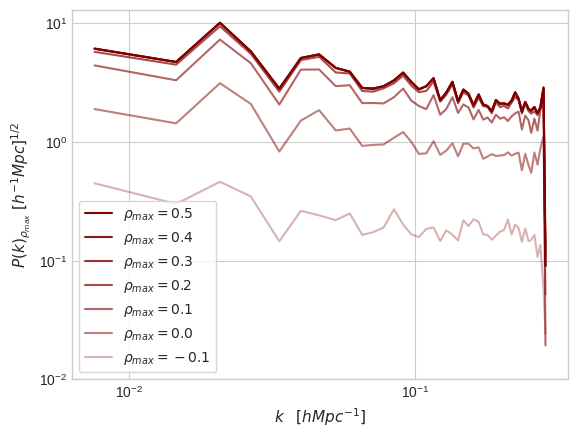

In [270]:
Pk_1_dens_05 = [ 6.11064845,  4.71859084, 10.09119816,  5.78587977,  2.8059622 ,
        5.09643793,  5.46077784,  4.2071859 ,  3.90858613,  2.84929545,
        2.81983068,  2.94556584,  3.30201696,  3.84628409,  3.20683521,
        2.77458236,  2.95089076,  3.45188315,  2.24083089,  2.60707097,
        3.21035321,  2.20296721,  2.76372701,  2.54902526,  2.04679106,
        2.51481335,  2.0638819 ,  2.0058899 ,  1.82159012,  2.25088876,
        2.09964636,  2.11389711,  2.06121398,  2.23588657,  2.61752177,
        2.31439549,  1.80635911,  2.16804147,  1.89735434,  1.83903417,
        1.970315  ,  1.74730599,  1.93255832,  2.8078711 ,  0.09014743]

Pk_1_dens_04 = [ 6.11064845,  4.71859084, 10.09119816,  5.78587977,  2.8059622 ,
        5.09643793,  5.46077784,  4.2071859 ,  3.90858613,  2.84929545,
        2.81983068,  2.94556584,  3.30201696,  3.84628409,  3.20683521,
        2.77458236,  2.95089076,  3.45188315,  2.24083089,  2.60707097,
        3.21035321,  2.20296721,  2.76372701,  2.54902526,  2.04679106,
        2.51481335,  2.0638819 ,  2.0058899 ,  1.82159012,  2.25088876,
        2.09964636,  2.11389711,  2.06121398,  2.23588657,  2.61752177,
        2.31439549,  1.80635911,  2.16804147,  1.89735434,  1.83903417,
        1.970315  ,  1.74730599,  1.93255832,  2.8078711 ,  0.09014743]

Pk_1_dens_03 = [ 6.0855961 ,  4.70003068, 10.05150476,  5.77011593,  2.80832605,
        5.07740244,  5.45727713,  4.1819295 ,  3.89805572,  2.83827244,
        2.77696083,  2.9529405 ,  3.26379214,  3.80955227,  3.18624008,
        2.75383887,  2.94006346,  3.4237466 ,  2.25699455,  2.59934295,
        3.19866426,  2.19727692,  2.75199134,  2.55141296,  2.02160791,
        2.49559858,  2.06510813,  1.9986783 ,  1.81132168,  2.25378863,
        2.08102239,  2.10042881,  2.04212294,  2.21777139,  2.60335035,
        2.31802099,  1.79449895,  2.17335669,  1.89815999,  1.82315615,
        1.94796537,  1.74297653,  1.94060493,  2.8741384 ,  0.10630593]

Pk_1_dens_02 = [5.7380948 , 4.47417777, 9.43165968, 5.52672799, 2.65089297,
       4.88593069, 5.21509108, 3.84960449, 3.76961145, 2.68209342,
       2.64958857, 2.82991318, 3.1137831 , 3.61812752, 2.98236237,
       2.62340544, 2.68783805, 3.23127537, 2.1846525 , 2.49862379,
       3.05471604, 2.11639847, 2.61780628, 2.4592546 , 1.94765156,
       2.35266815, 1.9999302 , 1.9700871 , 1.73724315, 2.15958973,
       1.96275939, 2.02052913, 1.9136644 , 2.13997281, 2.39226909,
       2.24368716, 1.7294732 , 2.10850683, 1.81855533, 1.73014305,
       1.80894492, 1.67945709, 1.98746115, 2.88831387, 0.1274146 ]

Pk_1_dens_01 = [4.40995717, 3.30575144, 7.27958286, 4.60032944, 2.06498192,
       4.06214811, 4.07413278, 2.94997903, 3.00429167, 2.12261778,
       2.12551827, 2.11083657, 2.38005013, 2.81463478, 2.22958496,
       2.00756755, 1.88808407, 2.47869487, 1.69386354, 1.89144348,
       2.38095241, 1.75100476, 2.06825902, 1.95222838, 1.54690849,
       1.86063003, 1.53947873, 1.60692565, 1.45725488, 1.69530366,
       1.56955885, 1.61266434, 1.50069943, 1.64060392, 1.73988386,
       1.80085966, 1.26961264, 1.66382917, 1.52248973, 1.19178356,
       1.56936388, 1.24599966, 1.83729833, 2.66478073, 0.01929182]

Pk_1_dens_00 = [1.89011608, 1.43315259, 3.12349158, 2.08801311, 0.82971432,
       1.51126203, 1.8515789 , 1.24793593, 1.29570243, 0.92510091,
       0.94394434, 0.95211398, 1.08225588, 1.21123618, 1.00163128,
       0.7924895 , 0.80112929, 1.01436895, 0.7770229 , 0.8443627 ,
       0.97338816, 0.75582672, 0.96411085, 0.96613686, 0.88044392,
       0.89929588, 0.72017209, 0.75219985, 0.78850593, 0.76178097,
       0.76658463, 0.77492146, 0.81674529, 0.76546049, 0.79475324,
       0.81194558, 0.57590244, 0.79445776, 0.6367259 , 0.54877115,
       0.81406108, 0.64359464, 0.87495716, 1.12140661, 0.05200191]


Pk_1_dens_minus_01 = [0.44822468, 0.30045527, 0.46097544, 0.34708193, 0.14558055,
       0.2624483 , 0.24071432, 0.2189149 , 0.24966554, 0.16471373,
       0.1738166 , 0.18995356, 0.27090045, 0.20124338, 0.16649701,
       0.15782727, 0.18481882, 0.19038902, 0.14635949, 0.17977007,
       0.16530353, 0.14798028, 0.21867781, 0.1951494 , 0.2229245 ,
       0.21203992, 0.1659435 , 0.16472823, 0.15002599, 0.16229098,
       0.17578096, 0.18043728, 0.22196842, 0.16554902, 0.20140182,
       0.1878351 , 0.14397   , 0.18710418, 0.14592599, 0.14912974,
       0.16450332, 0.10762928, 0.13591034, 0.05771137, 0.0241755 ]
all_k = [0.00758448, 0.01460929, 0.02077932, 0.02663351, 0.03348129,
       0.03981954, 0.04610165, 0.05269256, 0.05898465, 0.06519801,
       0.07126154, 0.0774446 , 0.08412105, 0.09057873, 0.09668622,
       0.102799  , 0.10909239, 0.11568088, 0.12202115, 0.12810056,
       0.13462632, 0.14088052, 0.14694161, 0.15309075, 0.15953496,
       0.16617671, 0.17240101, 0.17839371, 0.18466201, 0.19096622,
       0.19743072, 0.20379825, 0.21016832, 0.21658762, 0.22286959,
       0.2290856 , 0.23530518, 0.24173466, 0.24808696, 0.25358301,
       0.26012469, 0.26679494, 0.27290175, 0.27993688, 0.28434451]




labels = [r'$\rho_{max}=0.5$', r'$\rho_{max}=0.4$', r'$\rho_{max}=0.3$', r'$\rho_{max}=0.2$',
          r'$\rho_{max}=0.1$', r'$\rho_{max}=0.0$', r'$\rho_{max}=-0.1$']
plt.plot(all_k, Pk_1_dens_05, color = 'maroon',  alpha = 1.0, label = labels[0], linewidth = 1.5)
plt.plot(all_k, Pk_1_dens_04, color = 'maroon',  alpha = 0.9, label = labels[1], linewidth = 1.5)
plt.plot(all_k, Pk_1_dens_03, color = 'maroon',  alpha = 0.8, label = labels[2], linewidth = 1.5)
plt.plot(all_k, Pk_1_dens_02, color = 'maroon',  alpha = 0.7, label = labels[3], linewidth = 1.5)
plt.plot(all_k, Pk_1_dens_01, color = 'maroon',  alpha = 0.6, label = labels[4], linewidth = 1.5)
plt.plot(all_k, Pk_1_dens_00, color = 'maroon',  alpha = 0.5, label = labels[5], linewidth = 1.5)
plt.plot(all_k, Pk_1_dens_minus_01, color = 'maroon',  alpha = 0.3, label = labels[6], linewidth = 1.5)

#plt.title('Power Spectra')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$   $[hMpc^{-1}]$', fontsize = 11)
plt.ylabel(r'$P(k)_{\rho_{max}}$ $[h^{-1}Mpc]^{1/2}$', fontsize = 11)
plt.ylim(1e-2,13)
plt.legend(frameon = True)
plt.show()




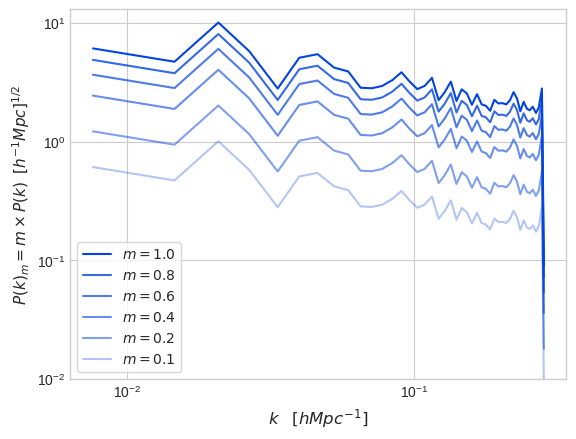

In [271]:
Pk_1_10 = [ 6.11064845,  4.71859084, 10.09119816,  5.78587977,  2.8059622 ,
        5.09643793,  5.46077784,  4.2071859 ,  3.90858613,  2.84929545,
        2.81983068,  2.94556584,  3.30201696,  3.84628409,  3.20683521,
        2.77458236,  2.95089076,  3.45188315,  2.24083089,  2.60707097,
        3.21035321,  2.20296721,  2.76372701,  2.54902526,  2.04679106,
        2.51481335,  2.0638819 ,  2.0058899 ,  1.82159012,  2.25088876,
        2.09964636,  2.11389711,  2.06121398,  2.23588657,  2.61752177,
        2.31439549,  1.80635911,  2.16804147,  1.89735434,  1.83903417,
        1.970315  ,  1.74730599,  1.93255832,  2.8078711 ,  0.09014743]

Pk_1_08 = [4.88851876, 3.77487267, 8.07295853, 4.62870382, 2.24476976,
       4.07715034, 4.36862228, 3.36574872, 3.1268689 , 2.27943636,
       2.25586454, 2.35645267, 2.64161357, 3.07702728, 2.56546817,
       2.21966589, 2.36071261, 2.76150652, 1.79266471, 2.08565678,
       2.56828257, 1.76237377, 2.21098161, 2.03922021, 1.63743285,
       2.01185068, 1.65110552, 1.60471192, 1.4572721 , 1.80071101,
       1.67971709, 1.69111769, 1.64897118, 1.78870925, 2.09401741,
       1.85151639, 1.44508729, 1.73443318, 1.51788347, 1.47122734,
       1.576252  , 1.39784479, 1.54604665, 2.24629688, 0.07211795]

Pk_1_06 = [3.66638907, 2.83115451, 6.0547189 , 3.47152786, 1.68357732,
       3.05786276, 3.27646671, 2.52431154, 2.34515168, 1.70957727,
       1.69189841, 1.7673395 , 1.98121018, 2.30777046, 1.92410113,
       1.66474941, 1.77053446, 2.07112989, 1.34449854, 1.56424258,
       1.92621193, 1.32178033, 1.65823621, 1.52941516, 1.22807464,
       1.50888801, 1.23832914, 1.20353394, 1.09295407, 1.35053325,
       1.25978782, 1.26833827, 1.23672839, 1.34153194, 1.57051306,
       1.3886373 , 1.08381547, 1.30082488, 1.1384126 , 1.1034205 ,
       1.182189  , 1.04838359, 1.15953499, 1.68472266, 0.05408846]

Pk_1_04 = [2.44425938, 1.88743634, 4.03647926, 2.31435191, 1.12238488,
       2.03857517, 2.18431114, 1.68287436, 1.56343445, 1.13971818,
       1.12793227, 1.17822634, 1.32080679, 1.53851364, 1.28273408,
       1.10983294, 1.1803563 , 1.38075326, 0.89633236, 1.04282839,
       1.28414129, 0.88118688, 1.10549081, 1.0196101 , 0.81871643,
       1.00592534, 0.82555276, 0.80235596, 0.72863605, 0.9003555 ,
       0.83985855, 0.84555884, 0.82448559, 0.89435463, 1.04700871,
       0.9257582 , 0.72254365, 0.86721659, 0.75894173, 0.73561367,
       0.788126  , 0.6989224 , 0.77302333, 1.12314844, 0.03605897]

Pk_1_02 = [1.22212969, 0.94371817, 2.01823963, 1.15717595, 0.56119244,
       1.01928759, 1.09215557, 0.84143718, 0.78171723, 0.56985909,
       0.56396614, 0.58911317, 0.66040339, 0.76925682, 0.64136704,
       0.55491647, 0.59017815, 0.69037663, 0.44816618, 0.52141419,
       0.64207064, 0.44059344, 0.5527454 , 0.50980505, 0.40935821,
       0.50296267, 0.41277638, 0.40117798, 0.36431802, 0.45017775,
       0.41992927, 0.42277942, 0.4122428 , 0.44717731, 0.52350435,
       0.4628791 , 0.36127182, 0.43360829, 0.37947087, 0.36780683,
       0.394063  , 0.3494612 , 0.38651166, 0.56157422, 0.01802949]

Pk_1_01 = [0.61106485, 0.47185908, 1.00911982, 0.57858798, 0.28059622,
       0.50964379, 0.54607778, 0.42071859, 0.39085861, 0.28492955,
       0.28198307, 0.29455658, 0.3302017 , 0.38462841, 0.32068352,
       0.27745824, 0.29508908, 0.34518831, 0.22408309, 0.2607071 ,
       0.32103532, 0.22029672, 0.2763727 , 0.25490253, 0.20467911,
       0.25148134, 0.20638819, 0.20058899, 0.18215901, 0.22508888,
       0.20996464, 0.21138971, 0.2061214 , 0.22358866, 0.26175218,
       0.23143955, 0.18063591, 0.21680415, 0.18973543, 0.18390342,
       0.1970315 , 0.1747306 , 0.19325583, 0.28078711, 0.00901474]



all_k = [0.00758448, 0.01460929, 0.02077932, 0.02663351, 0.03348129,
       0.03981954, 0.04610165, 0.05269256, 0.05898465, 0.06519801,
       0.07126154, 0.0774446 , 0.08412105, 0.09057873, 0.09668622,
       0.102799  , 0.10909239, 0.11568088, 0.12202115, 0.12810056,
       0.13462632, 0.14088052, 0.14694161, 0.15309075, 0.15953496,
       0.16617671, 0.17240101, 0.17839371, 0.18466201, 0.19096622,
       0.19743072, 0.20379825, 0.21016832, 0.21658762, 0.22286959,
       0.2290856 , 0.23530518, 0.24173466, 0.24808696, 0.25358301,
       0.26012469, 0.26679494, 0.27290175, 0.27993688, 0.28434451]


labels = [r'$m=1.0$', r'$m=0.8$', r'$m=0.6$', r'$m=0.4$', r'$m=0.2$', r'$m=0.1$']
plt.plot(all_k, Pk_1_10, color = 'xkcd:blue', alpha = 1.0, label = labels[0], linewidth = 1.5)
plt.plot(all_k, Pk_1_08, color = 'xkcd:blue', alpha = 0.8, label = labels[1], linewidth = 1.5)
plt.plot(all_k, Pk_1_06, color = 'xkcd:blue', alpha = 0.7,  label = labels[2], linewidth = 1.5)
plt.plot(all_k, Pk_1_04, color = 'xkcd:blue', alpha = 0.6,  label = labels[3], linewidth = 1.5)
plt.plot(all_k, Pk_1_02, color = 'xkcd:blue', alpha = 0.5,  label = labels[4], linewidth = 1.5)
plt.plot(all_k, Pk_1_01, color = 'xkcd:blue', alpha = 0.3,  label = labels[5], linewidth = 1.5)

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$   $[hMpc^{-1}]$', fontsize = 12)
plt.ylabel(r'$P(k)_m = m \times P(k)$  $[h^{-1}Mpc]^{1/2}$', fontsize = 11)
plt.ylim(1e-2,13)
plt.legend(frameon = True)
plt.show()




## Checking whether this code has GPU access and CUDA support, and if yes, how many GPUs can be used

In [272]:
# use GPUs if available
import torch.backends.cudnn as cudnn

if torch.cuda.is_available():
    print("Using CUDA")
    #index = 0
    #torch.cuda.set_device(index)
    device = torch.device('cuda')
else:
    print('CUDA Not Available')
    device1 = torch.device('cpu')
cudnn.benchmark = True      #May train faster but cost more memory


if (device == torch.device('cuda')):
    if torch.cuda.device_count() > 1:
        print("%d GPUs Available"%(torch.cuda.device_count()))
    print('GPU model:',torch.cuda.get_device_name())

else:
    print('Using CPU (Cuda unavailable)\n')
    

#print('Currently using device #:',torch.cuda.current_device())

Using CUDA
3 GPUs Available
GPU model: Tesla V100-SXM2-32GB


## Defining the location of the weights and _Optuna_ database on the _Rusty_ cluster

#### (In this analysis, the model trained on the original power spectra are used regardless of the cuts made on the test dataset, hence only the weights of the original P(k) are taken)

In [273]:
'''if case == 'original':
    dir_wt = '/mnt/ceph/users/alahiry/power_spectra/{}'.format(case)
    study_name = 'AstroNone_Pk_{}'.format(case)
    storage    = 'sqlite:///{}/AstroNone_Pk_{}.db'.format(dir_wt, case)

else:
    dir_wt = '/mnt/ceph/users/alahiry/power_spectra/{}/{}'.format(case, dens_cut_str)
    study_name = 'AstroNone_Pk_{}_{}'.format(case, dens_cut_str)
    storage    = 'sqlite:///{}/AstroNone_Pk_{}_{}.db'.format(dir_wt, case, dens_cut_str)'''
    
    
#Location for the original power spectra training weights and Optuna databases    
case1 = 'original'
dir_wt = '/mnt/ceph/users/alahiry/power_spectra/{}'.format(case1)
study_name = 'AstroNone_Pk_{}'.format(case1)
storage    = 'sqlite:///{}/AstroNone_Pk_{}.db'.format(dir_wt, case1)
    
    
print('Folder: ' + dir_wt)

#Loading Optuna Study
study = optuna.load_study(study_name = study_name, storage = storage)

print('Study name: "{}" loaded!'.format(study_name))

best_trial = study.best_trial
best_trial_num = best_trial.number

#Showing the best optimised model hyperparameters
print('\nBest model parameters:\n')
for key, value in best_trial.params.items():
    print("{}: {}".format(key, value))
print('Loss = ', best_trial.value)
params_final = best_trial.params
print('\nBest trial number: ', best_trial_num)

#Defining the model with those parameters and moving the model to GPUs
#accounting for data parallelisation
model = Model_Pk(params_final)
if (device == torch.device('cuda')):
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model) 
model.to(device)    


#Loading the best model weights
#fweights_best =  dir_wt + '/weights_{}.pt'.format(best_trial_num)  
fweights_best =  dir_wt + '/weights_best.pt'

#if the path to the best weights file exists, loading them into the model:
if os.path.exists(fweights_best):  
    model.load_state_dict(torch.load(fweights_best, map_location=torch.device(device)))
print('\nModel and weights loaded!')

#displaying the total number of model parameters
total_params = sum(t.numel() for t in model.parameters())
print('\ntotal number of parameters in the model = %d'%total_params)

Folder: /mnt/ceph/users/alahiry/power_spectra/original
Study name: "AstroNone_Pk_original" loaded!

Best model parameters:

alpha: 0.13675798557499638
hidden: 159
lr: 4.102915788654486e-06
wd: 1.608970137425372e-07
Loss =  0.00011599007848417386

Best trial number:  39

Model and weights loaded!

total number of parameters in the model = 1173421


## Evaluating the Test dataset

In [274]:
for Pk, A_true in test_dl:
    model.eval()
    with torch.no_grad():
        Pk = Pk.to(device)
        A_true = A_true.to(device)
        A_nn = model(Pk)

A_nn = A_nn.cpu().numpy().flatten()
A_true = A_true.cpu().numpy().flatten()

A_nn = A_nn*(1.2-0.8) + 0.8
A_true = A_true*(1.2-0.8) + 0.8

## Neural Network Preduiction vs True Value Plot

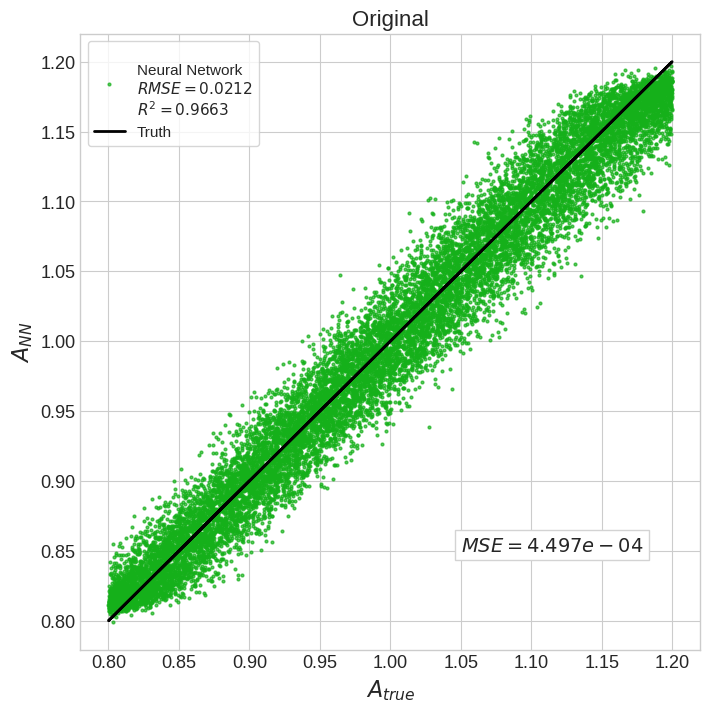

In [275]:
from sklearn.metrics import mean_squared_error, r2_score
test_loss = mean_squared_error(A_true, A_nn)
test_r2_value = r2_score(A_true, A_nn)

plt.style.use('seaborn-whitegrid')

if case == 'max':
    rho = r'$\rho_{max} =$' + dens_cut_str
    
elif case == 'min':
    rho = r'$\rho_{min} =$' + dens_cut_str

else:
    rho = 'Original'
    
plt.figure(figsize = (8,8))
plt.scatter(A_true, A_nn, s = 4, color = 'xkcd:green', alpha = 0.7, label = '\nNeural Network\n$RMSE = {:.4f}$\n$R^2 = {:.4f}$'.format(np.sqrt(test_loss), test_r2_value))
plt.plot(A_true, A_true, color = 'black', linewidth = 2, label = 'Truth')
plt.xlabel('$A_{true}$', fontsize = 16)
plt.ylabel('$A_{NN}$', fontsize = 16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title(rho, fontsize = 16)
plt.legend(fontsize = 11, frameon=True)
plt.text(1.05, 0.85, r"$MSE = {:.3e}$".format(test_loss), fontsize = 14, bbox=dict(facecolor='white', edgecolor='lightgray'))
plt.show()

## Distribution of $A_{NN}$ with different values of $A_{True}$

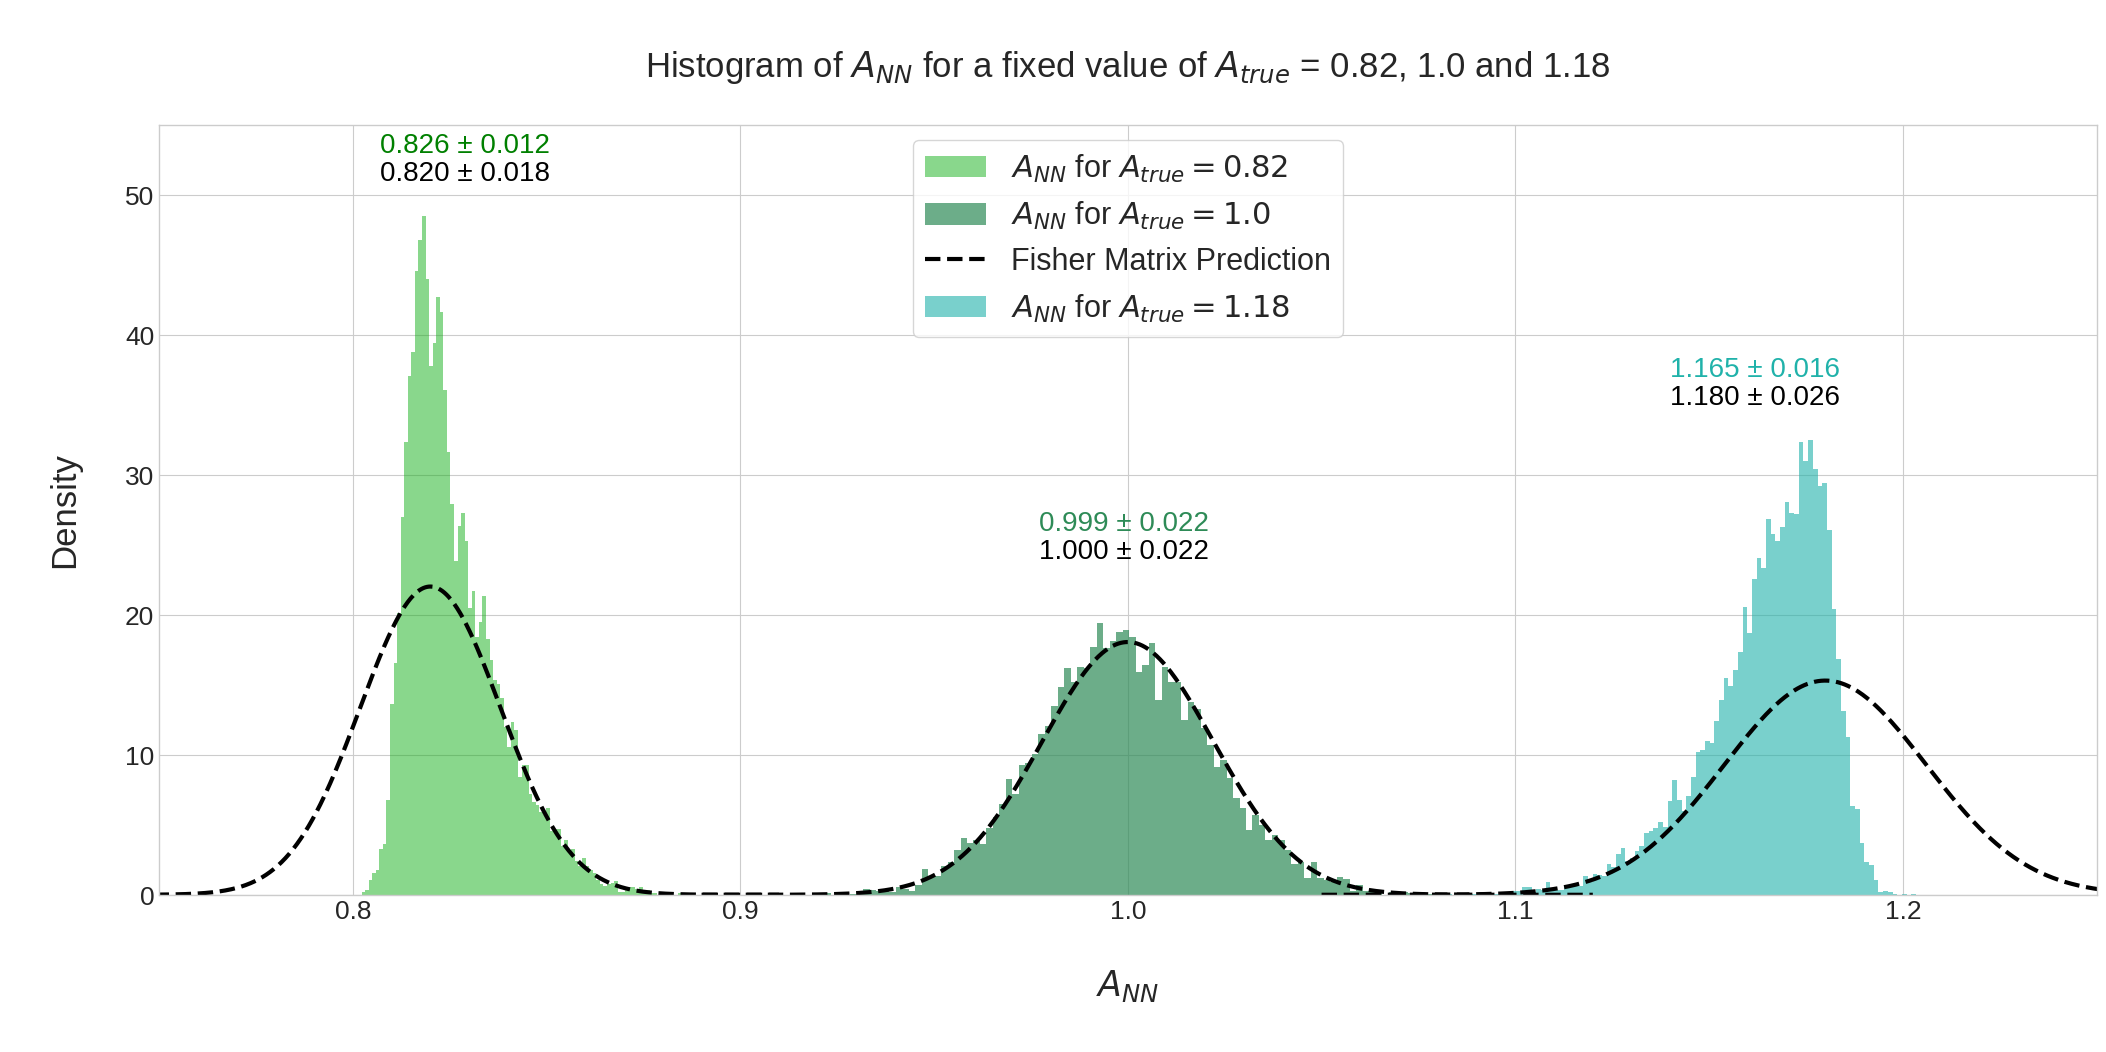

In [278]:
n = 10000
idx = np.random.permutation(n)

data_set_hist_100 = data_gen(n, 'all', 'original', None, 1.0, 1.0)
test_dl_hist_100 = DataLoader(data_set_hist_100, batch_size = n, shuffle=True)

data_set_hist_082 = data_gen(n, 'all', 'original', None, 1.0, 0.82)
test_dl_hist_082 = DataLoader(data_set_hist_082, batch_size = n, shuffle=True)

data_set_hist_118 = data_gen(n, 'all', 'original', None, 1.0, 1.18)
test_dl_hist_118 = DataLoader(data_set_hist_118, batch_size = n, shuffle=True)


A_pred_hist = np.zeros((3,n))
A_true_hist = np.zeros((3,n))

mse_final = np.zeros(3)
rmse_final = np.zeros(3)

test_dl_hist_list = [test_dl_hist_082, test_dl_hist_100, test_dl_hist_118]

for j in range(3):
    for images, labels in test_dl_hist_list[j]:
        model.eval()
        images = images.to(device)
        labels = labels.to(device)
        out = model(images)

    for i in range(len(images)):
        A_pred_hist[j][i] = out[i].item()*(1.2-0.8) + 0.8
        A_true_hist[j][i] = labels[i].item()*(1.2-0.8) + 0.8


    from sklearn.metrics import mean_squared_error
    mse = mean_squared_error(A_pred_hist[j], A_true_hist[j])
    #print('Mean Squared Error (MSE) = ',mse)
    #print('Root Mean Squared Error (RMSE) = ', np.sqrt(mse))
    #print('\n')
    mse_final[j] = mse
    rmse_final[j] = np.sqrt(mse)

mu_theory = 0.82
std_theory = 0.82*np.sqrt(2)/64

from scipy.stats import norm

fig,ax = plt.subplots(figsize = (25,10))

plt.style.use('seaborn-whitegrid')

mu_th_1 = 0.82
std_th_1 = 0.82*np.sqrt(2)/64
#ax.hist(A_pred[0], bins = 100, density = True, color = 'green', histtype='step', linewidth=1)
ax.hist(A_pred_hist[0], bins = 100, density = True, color = 'xkcd:green', alpha = 0.5, label = '$A_{NN}$ for $A_{true} = 0.82$')
xmin1, xmax1 = 0.7, 0.91
x1 = np.linspace(xmin1-0.04, xmax1, 1000)
p_fit_1 = norm.pdf(x1, mu_th_1, std_th_1)
ax.plot(x1, p_fit_1, color = 'black', linewidth=3, linestyle='dashed')
ax.text(0.807, 53, "{:.3f} ± {:.3f}".format(np.mean(A_pred_hist[0]), np.std(A_pred_hist[0])), fontsize = 20, color = 'green')
ax.text(0.807, 51, "{:.3f} ± {:.3f}".format(mu_th_1, std_th_1), fontsize = 20, color = 'black')


mu_th_2 = 1.0
std_th_2 = 1.0*np.sqrt(2)/64
#ax.hist(A_pred[1], bins = 100, density = True, color = 'green', histtype='step', linewidth=1, label = 'Neural Network Prediction')
ax.hist(A_pred_hist[1], bins = 100, density = True, color = 'seagreen', alpha = 0.7, label = '$A_{NN}$ for $A_{true} = 1.0$')
xmin2, xmax2 = 0.89, 1.12
x2 = np.linspace(xmin2, xmax2, 1000)
p_fit_2 = norm.pdf(x2, mu_th_2, std_th_2)
ax.plot(x2, p_fit_2, color = 'black', linewidth=3, linestyle='dashed', label = 'Fisher Matrix Prediction')
ax.text(0.977, 26, "{:.3f} ± {:.3f}".format(np.mean(A_pred_hist[1]), np.std(A_pred_hist[1])), fontsize = 20, color = 'seagreen')
ax.text(0.977, 24, "{:.3f} ± {:.3f}".format(mu_th_2, std_th_2), fontsize = 20, color = 'black')



mu_th_3 = 1.18
std_th_3 = 1.18*np.sqrt(2)/64
#ax.hist(A_pred[2], bins = 100, density = True, color = 'green', histtype='step', linewidth=1)
ax.hist(A_pred_hist[2], bins = 100, density = True, color = 'lightseagreen', alpha = 0.6, label = '$A_{NN}$ for $A_{true} = 1.18$')
xmin3, xmax3 = 1.05,1.3
x3 = np.linspace(xmin3, xmax3 + 0.04, 1000)
p_fit_3 = norm.pdf(x3, mu_th_3, std_th_3)
ax.plot(x3, p_fit_3, color = 'black', linewidth=3, linestyle='dashed')
ax.text(1.14, 37, "{:.3f} ± {:.3f}".format(np.mean(A_pred_hist[2]), np.std(A_pred_hist[2])), fontsize = 20, color = 'lightseagreen', label = 'Neural Network')
ax.text(1.14, 35, "{:.3f} ± {:.3f}".format(mu_th_3, std_th_3), fontsize = 20, color = 'black')

ax.xaxis.get_ticklocs(minor=True)
ax.minorticks_on()

plt.ylim(0,55)
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.xlim(0.75,1.25)
plt.xlabel('\n$A_{NN}$\n', fontsize = 25)
plt.ylabel('\nDensity\n', fontsize = 25)
plt.title('\nHistogram of $A_{NN}$ for a fixed value of $A_{true}$ = 0.82, 1.0 and 1.18\n', fontsize = 25)
plt.legend(loc = 9, fontsize = 22, frameon = True)
plt.show()

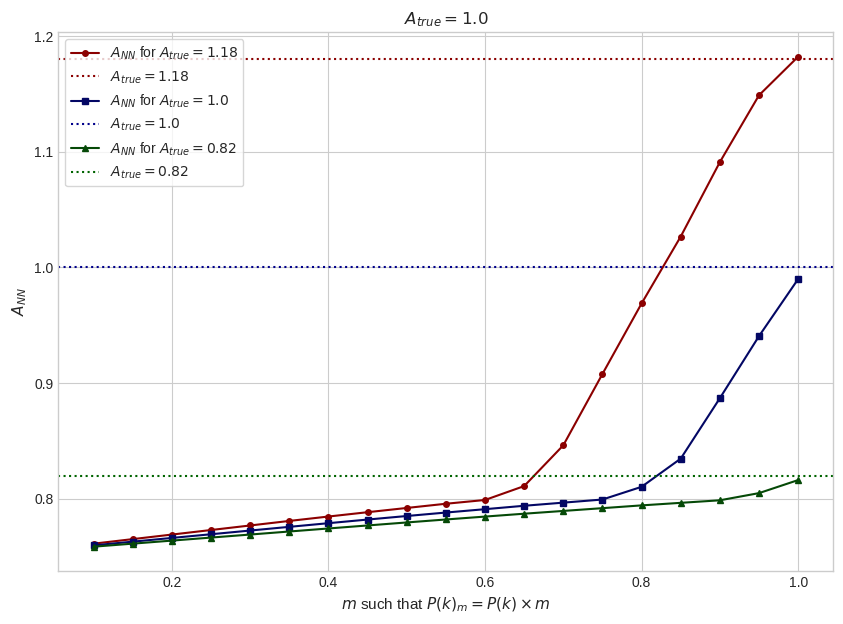

In [49]:
import numpy as np

A_nn_100   = [0.98994297, 0.940626, 0.8869682, 0.83474004, 0.81037426, 0.79939735, 0.79670465, 0.79399973, 0.791052, 0.7881444, 0.785149,
              0.78209275, 0.77894986, 0.7757841, 0.7725944, 0.76939183, 0.7661959, 0.7629961, 0.75979686]

A_nn_082   = [0.81621367, 0.80493397, 0.7987385, 0.79654056, 0.7943371, 0.79193676, 0.7895393, 0.787143, 0.784661, 0.78215474, 0.7795819,
              0.7769927, 0.77438205, 0.7717637, 0.7691353, 0.76651496, 0.7638928, 0.76126856, 0.75864416]

A_nn_118   = [1.1821263, 1.1487854, 1.091003, 1.0266709, 0.9688195, 0.9078891, 0.8462503, 0.8110124, 0.7990029, 0.795744, 0.79211104,
              0.78844225, 0.7847025, 0.7808951, 0.7769715, 0.77304703, 0.7691154, 0.7651856, 0.7612476]


#A_nn   = [1.044, 1.046, 1.048, 1.050, 1.052, 1.053, 1.055, 1.057, 1.060,
#          1.062, 1.064, 1.067, 1.069]

#A_nn = np.asarray(A_nn)/1.0445478

m = [1.0,0.95,0.9,0.85,0.8,0.75,0.7,0.65,0.6,0.55,0.5,0.45,0.4,0.35,0.3,0.25,0.2,0.15,0.1]

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

plt.style.use('default')
plt.style.use('seaborn-whitegrid')

plt.figure(figsize = (10,7))

plt.plot(m, A_nn_118, marker = 'o', markersize = 4, color = 'darkred', label = r'$A_{NN}$ for $A_{true} = 1.18$')
plt.axhline(y = 1.18, color = 'darkred', linestyle = 'dotted', label = r'$A_{true} = 1.18$')

plt.plot(m, A_nn_100, marker = 's', markersize = 4, color = 'xkcd:darkblue', label = r'$A_{NN}$ for $A_{true} = 1.0$')
plt.axhline(y = 1.0, color = 'darkblue', linestyle = 'dotted', label = r'$A_{true} = 1.0$')

plt.plot(m, A_nn_082, marker = '^', markersize = 4, color = 'xkcd:darkgreen', label = r'$A_{NN}$ for $A_{true} = 0.82$')
plt.axhline(y = 0.82, color = 'darkgreen', linestyle = 'dotted', label = r'$A_{true} = 0.82$')

#plt.xticks(ticks = m)

'''y_ticks = [-10,-8,-6,-4,-2,0, 1]
plt.yticks(ticks = y_ticks)'''

#plt.yticks(ticks = A_nn)

plt.title(r'$A_{true} = 1.0$')
plt.xlabel(r'$m$ such that $P(k)_m = P(k) \times m$', fontsize = 11)
plt.ylabel(r'$A_{NN}$', fontsize = 11)
plt.legend(frameon=True)
plt.show()